In [3]:
import jax
import jax.numpy as jnp
import optax
import flax.nnx as nnx
from flax.training import train_state
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import jax
import jax.numpy as jnp
import flax.nnx as nnx
from jax import random
from flax import serialization
import json
import optax
import numpy as np
from sklearn.utils.estimator_checks import check_is_fitted
from sklearn.base import BaseEstimator, _fit_context
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm # progress bar
from sklearn.preprocessing import StandardScaler
import logging
from tqdm import trange
from matplotlib.pyplot import plot
import joblib
import msgpack
import pathlib
import os
import sys

try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # __file__ is not defined in Jupyter, so use current working directory
    BASE_DIR = os.getcwd()

DRAWINGS_PATH = os.path.abspath(os.path.join(BASE_DIR, "../../../Drawings"))
sys.path.append(DRAWINGS_PATH)

GRADIENT_NN_SRC = os.path.abspath(os.path.join(BASE_DIR, "../../Code/Gradient NN/src"))
sys.path.append(GRADIENT_NN_SRC)

import meshlab_functions as mf
import solidworks_functions as sf
import geometric_functions as gf


In [ ]:
pointcloud = np.loadtxt("../../Leihui Code/dataset/SelfGeneratedClouds/Chain_wheel05mm.xyz", usecols=(0, 1, 2)) # NOTE: Load the saved pointcloud
pc_w_holes = mf.create_mesh_holes(pointcloud,40, 10) # NOTE: Create mesh holes

print(pointcloud.shape)
print(pc_w_holes.shape)

np.savetxt("../Data/Training_data/Gear_w_holes_40_10.txt", pc_w_holes, fmt='%.3f', delimiter=' ')

(35947, 3)
(34897, 3)


In [ ]:
feature, grad, radius = gf.Get_variables("../Data/Training_data/Gear_w_holes_40_10.txt", k=20, save="no") # NOTE: Get the features from the pointcloud


features = np.hstack((feature, grad.reshape(-1,1))) # NOTE: Stack the features, gradients and radius together
print(features.shape)

np.savetxt("../Data/Training_data/Gear_w_holes_features_40_10.txt", features, fmt='%.3f', delimiter=' ')

c:\Users\magnu\anaconda3\envs\rd\Lib\site-packages\pyntcloud\scalar_fields\eigenvalues.py:77: RuntimeWarning: invalid value encountered in power
  self.to_be_added[name] = np.nan_to_num((ev[:, 0] * ev[:, 1] * ev[:, 2]) ** (1 / 3))
c:\Users\magnu\anaconda3\envs\rd\Lib\site-packages\pyntcloud\scalar_fields\eigenvalues.py:77: RuntimeWarning: invalid value encountered in power
  self.to_be_added[name] = np.nan_to_num((ev[:, 0] * ev[:, 1] * ev[:, 2]) ** (1 / 3))
c:\Users\magnu\anaconda3\envs\rd\Lib\site-packages\pyntcloud\geometry\models\plane.py:17: RuntimeWarning: invalid value encountered in divide
  self.normal = normal / np.linalg.norm(normal)


(34897, 10)


In [13]:
# Explicit pairs (hole_size, num_holes)
hole_configs = [
    (0,0),
    (5, 60),
    (20, 50),
    (100, 30),
    (200, 20),
    (500, 10)
]

import numpy as np
import os

pointcloud = np.loadtxt("../../Leihui Code/dataset/SelfGeneratedClouds/Chain_wheel05mm.xyz", usecols=(0, 1, 2)) # NOTE: Load the saved pointcloud


for hole_size, num_holes in hole_configs:
    # Create holes
    pc_w_holes = mf.create_mesh_holes(pointcloud, num_holes, hole_size)
    print(f"Created holes: size={hole_size}, num={num_holes}")

    # Save holes
    holes_save_path = f"../Data/Training_data/Gear_w_holes_{hole_size}_{num_holes}.txt"
    np.savetxt(holes_save_path, pc_w_holes, fmt='%.3f', delimiter=' ')
    print(f"Saved holes: {holes_save_path}")

    # Features
    feature, grad, radius = gf.Get_variables(holes_save_path, k=20, save="no")
    features = np.hstack((feature, grad.reshape(-1, 1)))

    # Save features
    features_save_path = f"../Data/Training_data/Gear_w_holes_features_{hole_size}_{num_holes}.txt"
    np.savetxt(features_save_path, features, fmt='%.3f', delimiter=' ')
    print(f"Saved features: {features_save_path}")

Created holes: size=0, num=0
Saved holes: ../Data/Training_data/Gear_w_holes_0_0.txt
Saved features: ../Data/Training_data/Gear_w_holes_features_0_0.txt
Created holes: size=5, num=60
Saved holes: ../Data/Training_data/Gear_w_holes_5_60.txt
Saved features: ../Data/Training_data/Gear_w_holes_features_5_60.txt
Created holes: size=20, num=50
Saved holes: ../Data/Training_data/Gear_w_holes_20_50.txt
Saved features: ../Data/Training_data/Gear_w_holes_features_20_50.txt
Created holes: size=100, num=30
Saved holes: ../Data/Training_data/Gear_w_holes_100_30.txt
Saved features: ../Data/Training_data/Gear_w_holes_features_100_30.txt
Created holes: size=200, num=20
Saved holes: ../Data/Training_data/Gear_w_holes_200_20.txt
Saved features: ../Data/Training_data/Gear_w_holes_features_200_20.txt
Created holes: size=500, num=10
Saved holes: ../Data/Training_data/Gear_w_holes_500_10.txt
Saved features: ../Data/Training_data/Gear_w_holes_features_500_10.txt


In [1]:
import numpy as np

# Load the saved labels
labels = np.loadtxt("../Data/Training_data/holetest_label.txt")  # Replace with your actual file path

# Assuming your surface density is in the first column
surface_density_column = labels[:, 0]

# Count unique values and how many times each occurs
unique_values, counts = np.unique(surface_density_column, return_counts=True)

# Print them out
for value, count in zip(unique_values, counts):
    print(f"Label: {value:.3f}, Count: {count}")

Label: 1.304, Count: 504
Label: 2.607, Count: 81404


In [2]:

import pandas as pd
import sys
import numpy as np
import pythoncom
import argparse
import pickle
import jax 
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap
import torch
from scipy.spatial import cKDTree
from scipy.spatial import KDTree
import importlib
import random
import numpy.linalg as LA
import os
from tqdm import tqdm
from IPython.display import clear_output

# Import our own scripts:

BASE_DIR = os.getcwd()
DRAWINGS_PATH = os.path.abspath(os.path.join(BASE_DIR, "../../../Drawings"))
sys.path.append(DRAWINGS_PATH)
GRADIENT_NN_SRC = os.path.abspath(os.path.join(BASE_DIR, "../../Code/Gradient NN/src"))
sys.path.append(GRADIENT_NN_SRC)

import meshlab_functions as mf
import solidworks_functions as sf
import geometric_functions as gf

importlib.reload(mf)
importlib.reload(gf)
importlib.reload(sf)
############################

<module 'solidworks_functions' from 'c:\\Users\\magnu\\OneDrive\\Dokumenter\\GitHub\\R-D\\Drawings\\solidworks_functions.py'>

In [1]:
radius = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200] # NOTE: Define the radius for the holes

params = {"radius": radius}


In [ ]:
output_path_STL = os.path.join(BASE_DIR, "..", "Data", "Training_data", "timetest.stl")
output_path_xyz = os.path.join(BASE_DIR, "..", "Data", "Training_data", "timetest2.xyz")
model = sf.Create_geometry("ball", output_path_STL, params)
raw_pointcloud = mf.sample_stl_by_point_distance(output_path_STL, output_path_xyz, 1)
pointcloud = np.loadtxt(output_path_xyz, usecols=(0, 1, 2)) # NOTE: Load the saved pointcloud

    

✅ Trying to open part: c:\Users\magnu\OneDrive\Dokumenter\GitHub\R-D\Drawings\Ball\Ball.SLDPRT
💾 Saving to: c:\Users\magnu\OneDrive\Dokumenter\GitHub\R-D\Code\Gradient NN\Data\Training_data\timetest.stl
Geometry created and saved to c:\Users\magnu\OneDrive\Dokumenter\GitHub\R-D\Code\Gradient NN\src\..\Data\Training_data\timetest.stl


✅ Trying to open part: c:\Users\magnu\OneDrive\Dokumenter\GitHub\R-D\Drawings\Ball\Ball.SLDPRT
💾 Saving to: c:\Users\magnu\OneDrive\Dokumenter\GitHub\R-D\Code\Gradient NN\Data\Training_data\timetest.stl
Geometry created and saved to c:\Users\magnu\OneDrive\Dokumenter\GitHub\R-D\Code\Gradient NN\src\..\Data\Training_data\timetest.stl
✅ Resampled point cloud saved (XYZ only): c:\Users\magnu\OneDrive\Dokumenter\GitHub\R-D\Code\Gradient NN\src\..\Data\Training_data\timetest.xyz
Radius:    20 → Points:   3340 → Time: 1.481 sec
✅ Trying to open part: c:\Users\magnu\OneDrive\Dokumenter\GitHub\R-D\Drawings\Ball\Ball.SLDPRT
💾 Saving to: c:\Users\magnu\OneDrive\Dokumenter\GitHub\R-D\Code\Gradient NN\Data\Training_data\timetest.stl
Geometry created and saved to c:\Users\magnu\OneDrive\Dokumenter\GitHub\R-D\Code\Gradient NN\src\..\Data\Training_data\timetest.stl
✅ Resampled point cloud saved (XYZ only): c:\Users\magnu\OneDrive\Dokumenter\GitHub\R-D\Code\Gradient NN\src\..\Data\Training_data\timete

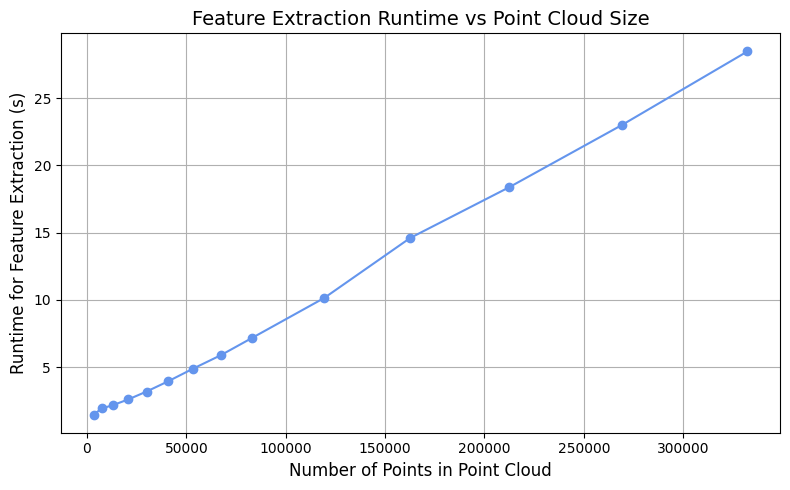

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# Different radius values (smaller radius → denser point cloud)
radius_list = [20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
num_points_list = []
runtimes = []

for radius in radius_list:
    # 1️⃣ Update params
    params = {"radius": radius}
    
    # 2️⃣ Create geometry and sample points
    output_path_STL = os.path.join(BASE_DIR, "..", "Data", "Training_data", "timetest.stl")
    output_path_xyz = os.path.join(BASE_DIR, "..", "Data", "Training_data", "timetest.xyz")
    model = sf.Create_geometry("ball", output_path_STL, params)
    
    raw_pointcloud = mf.sample_stl_by_point_distance(output_path_STL, output_path_xyz, 1)
    pointcloud = np.loadtxt(output_path_xyz, usecols=(0, 1, 2))
    
    num_points = len(pointcloud)
    num_points_list.append(num_points)
    
    # 3️⃣ Run your feature extraction and time it
    start_time = time.time()
    feature, grad, radius_data = gf.Get_variables(output_path_xyz, k=20, save="no")
    end_time = time.time()
    
    runtime = end_time - start_time
    runtimes.append(runtime)
    
    print(f"Radius: {radius:>5} → Points: {num_points:>6} → Time: {runtime:.3f} sec")

# Plot: Number of points vs Runtime
plt.figure(figsize=(8, 5))
plt.plot(num_points_list, runtimes, marker='o', linestyle='-', color='cornflowerblue')
plt.xlabel("Number of Points in Point Cloud", fontsize=12)
plt.ylabel("Runtime for Feature Extraction (s)", fontsize=12)
plt.title("Feature Extraction Runtime vs Point Cloud Size", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("pointcloud_runtime_plot.png", dpi=1000, bbox_inches='tight')
plt.show()

# # Plot: Radius vs Number of Points
# plt.figure(figsize=(8, 5))
# plt.plot(radius_list, num_points_list, marker='o', linestyle='-', color='darkorange')
# plt.xlabel("Radius Parameter", fontsize=12)
# plt.ylabel("Number of Points", fontsize=12)
# plt.title("Point Cloud Size vs Radius Parameter", fontsize=14)
# plt.grid(True)
# plt.tight_layout()


# plt.show()
